Для начала займемся загрузкой необходимых данных, мой номер по списку группы - 1 => используем колонку 'Sleep_Hours'

In [241]:
N = 1
cols = ['Daily_Usage_Hours', 'Sleep_Hours', 'Exercise_Hours', 'Screen_Time_Before_Bed', 'Time_on_Social_Media', 'Time_on_Gaming', 'Time_on_Education']
selected_column = cols[N % 7]
selected_column

'Sleep_Hours'

In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
import math

df = pd.read_csv('../../datasets/teen_phone_addiction_dataset.csv')
data = df[selected_column]

print('First 5 values')
print(data.head())

First 5 values
0    6.1
1    6.5
2    5.5
3    3.9
4    6.7
Name: Sleep_Hours, dtype: float64


Займемся выполнением задания I. А именно рассчитаем необходимые характеристики и построим графики

ХАРАКТЕРИСТИКИ ДАННЫХ:
Среднее: 6.4898
Дисперсия: 2.2222
Мода: 6.1000
Медиана: 6.5000
Квантиль 0.25: 5.5000
Квантиль 0.5: 6.5000
Квантиль 0.75: 7.5000
Асимметрия: 0.0119
Эксцесс: -0.2954
Интерквартильный размах (IQR): 2.0000


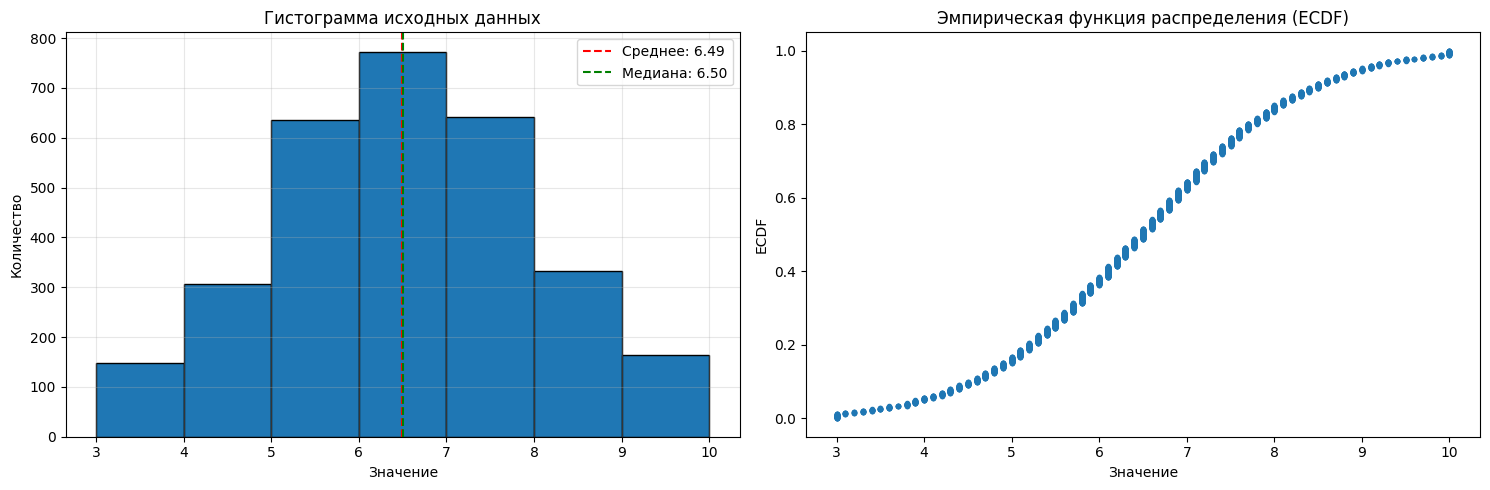

In [243]:

def characteristics_solve(data):
    mean_val = data.mean()
    var_val = data.var()
    mode_val = data.mode()[0]
    median_val = data.median()
    quantiles = data.quantile([0.25, 0.5, 0.75])
    skew_val = data.skew()
    kurtosis_val = data.kurtosis()
    iqr_val = quantiles[0.75] - quantiles[0.25]
    
    characteristics = {
        "Среднее": mean_val,
        "Дисперсия": var_val,
        "Мода": mode_val,
        "Медиана": median_val,
        "Квантиль 0.25": quantiles[0.25],
        "Квантиль 0.5": quantiles[0.5],
        "Квантиль 0.75": quantiles[0.75],
        "Асимметрия": skew_val,
        "Эксцесс": kurtosis_val,
        "Интерквартильный размах (IQR)": iqr_val
    }
    
    print("ХАРАКТЕРИСТИКИ ДАННЫХ:")
    for key, value in characteristics.items():
        print(f"{key}: {value:.4f}")
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    axes[0].hist(data, bins=7, edgecolor='black', density=False) 
    axes[0].axvline(mean_val, color='red', linestyle='--', label=f'Среднее: {mean_val:.2f}') 
    axes[0].axvline(median_val, color='green', linestyle='--', label=f'Медиана: {median_val:.2f}') 
    axes[0].set_title('Гистограмма исходных данных') 
    axes[0].set_xlabel('Значение') 
    axes[0].set_ylabel('Количество') 
    axes[0].legend() 
    axes[0].grid(True, alpha=0.3)  
    
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    axes[1].plot(x, y, marker='.', linestyle='none')
    axes[1].set_title('Эмпирическая функция распределения (ECDF)')
    axes[1].set_xlabel('Значение')
    axes[1].set_ylabel('ECDF')
    
    plt.tight_layout()
    plt.show()
characteristics_solve(data)

Выводы. Мат ожидание и медиана практически совпадают, что свидетельствует о симметричностии распределения, об этом же свидетельствует близкая к нулю ассиметрия. Дисперсия указывает на умеренный разброс данных вокруг среднего. Интерквартильный размах означает что 50% данных лежат в [5.5, 7.5]. Эксцесс отрицательный — указывает на некоторые различия по сравнению с нормальным (а именно менее выраженный пик и более значимые хвосты).
По графикам: распрделение очень похоже на нормальное, однако присутствуют отличия на хвостах, а именно отсутствуют значения <3, >10

Далее напишем хи квадрат метод Пирсона

In [244]:
def pirson(x, alpha=0.05, is_skip=True):
    def F(val): 
        return norm.cdf(val, loc=np.mean(x), scale=np.std(x, ddof=1))
    L = int(1 + 3.322 * np.log10(len(x)))
    arr = sorted(x)
    max_el = arr[-1]
    min_el = arr[0]
    step = (max_el - min_el) / L
    j = 0
    res = 0

    for i in np.arange(min_el + step, max_el + 1e-6, step):
        jstart = j
        while j < len(arr) and arr[j] < i:
            j += 1
        v = j - jstart
        if v <= 1 and is_skip:
            continue
        p = F(i) - F(i - step)
        res += (v - p * len(arr)) ** 2 / (p * len(arr))

    fdf = L - 1 - 2

    chi2_critical = stats.chi2.ppf(1 - alpha, fdf)

    return res, chi2_critical

chi2_stat, chi2_critical = pirson(data)

print("РЕЗУЛЬТАТЫ КРИТЕРИЯ ХИ-КВАДРАТ:")
print(f"Статистика: хи квадрат = {chi2_stat:.4f}")
print(f"Критическое значение (α=0.05): {chi2_critical:.4f}")
if chi2_stat > chi2_critical:
    print("Вывод: Отвергаем нулевую гипотезу. Распределение НЕ является нормальным.")
else:
    print("Вывод: Не отвергаем нулевую гипотезу. Нет оснований считать распределение отличным от нормального.")

РЕЗУЛЬТАТЫ КРИТЕРИЯ ХИ-КВАДРАТ:
Статистика: хи квадрат = 66.8627
Критическое значение (α=0.05): 16.9190
Вывод: Отвергаем нулевую гипотезу. Распределение НЕ является нормальным.


In [245]:
def skew_kurtosis_solve(data):
    n = len(data)
    se_skew = np.sqrt(6 * n * (n - 1) / ((n - 2) * (n + 1) * (n + 3)))
    se_kurtosis = np.sqrt(24 * n * (n - 1)**2 / ((n - 3) * (n - 2) * (n + 3) * (n + 5)))
    
    z_skew = data.skew() / se_skew
    z_kurtosis = data.kurtosis() / se_kurtosis
    
    alpha = 0.05
    z_critical = stats.norm.ppf(1 - alpha/2)
    
    print("\nРЕЗУЛЬТАТЫ КРИТЕРИЯ АСИММЕТРИИ И ЭКСЦЕССА:")
    print(f"Z-оценка асимметрии: {z_skew:.4f} (критическое значение ±{z_critical:.4f})")
    print(f"Z-оценка эксцесса: {z_kurtosis:.4f} (критическое значение ±{z_critical:.4f})")
    
    if abs(z_skew) > z_critical or abs(z_kurtosis) > z_critical:
        print("Вывод: Хотя бы один из коэффициентов значимо отличается от нуля. Распределение НЕ является нормальным.")
    else:
        print("Вывод: Ни один из коэффициентов не значимо отличается от нуля. Нет оснований отвергать нормальность.")
skew_kurtosis_solve(data)


РЕЗУЛЬТАТЫ КРИТЕРИЯ АСИММЕТРИИ И ЭКСЦЕССА:
Z-оценка асимметрии: 0.2652 (критическое значение ±1.9600)
Z-оценка эксцесса: -3.3059 (критическое значение ±1.9600)
Вывод: Хотя бы один из коэффициентов значимо отличается от нуля. Распределение НЕ является нормальным.


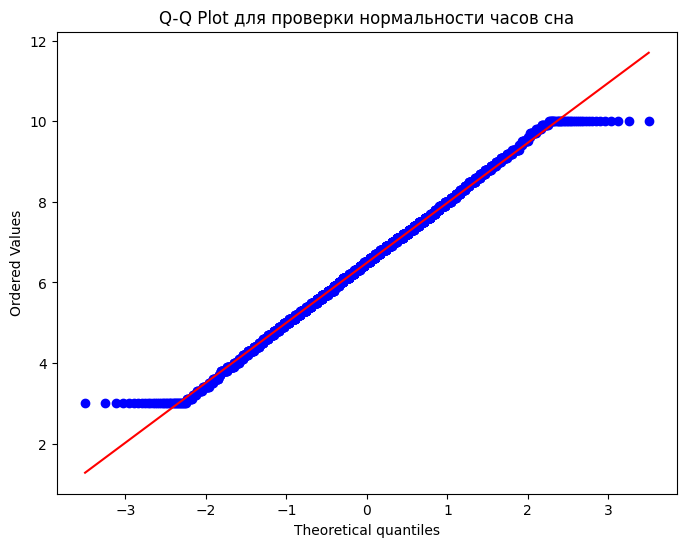

In [246]:

def qqplot(data):
    plt.figure(figsize=(8, 6))
    stats.probplot(data, dist="norm", plot=plt)
    plt.title('Q-Q Plot для проверки нормальности часов сна')
    plt.show()
qqplot(data)

На данном графике видно, что точки в основном ложатся вдоль прямой линии, но с большими отклонениями на хвостах. Это является визуальным подтверждением, что распределение не является нормальным.

Обработка данных, для приведения их к нормальному виду при помощи логарифмического преобразования:

In [247]:
data_log = np.log1p(data)

ХАРАКТЕРИСТИКИ ДАННЫХ:
Среднее: 1.9926
Дисперсия: 0.0435
Мода: 1.9601
Медиана: 2.0149
Квантиль 0.25: 1.8718
Квантиль 0.5: 2.0149
Квантиль 0.75: 2.1401
Асимметрия: -0.5441
Эксцесс: 0.1861
Интерквартильный размах (IQR): 0.2683


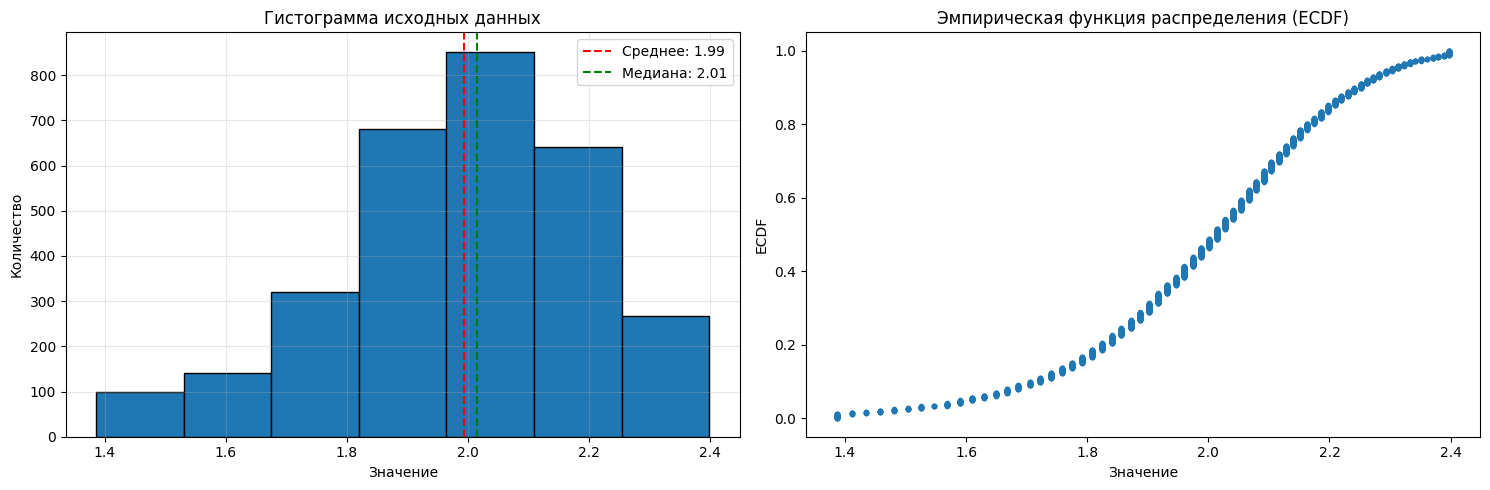

In [248]:
characteristics_solve(data_log)

Мат ожидание и медиана близки, но несколько различаются, мода чуть смещена влево, а асимметрия (-0.544) отрицательная, значит распределение смещено вправо (левый хвост длиннее). Эксцесс положительный, а значит распределение чуть более островершинное. Дисперсия и интерквартильный размах показывает очень малый разброс данных. Интерквартильный размах (IQR = 0.268) означает, что 50% данных лежат в очень узком диапазоне от 1.87 до 2.14. 

По графикам и имеющимся данным уже видно, что попытка сделать распределение нормальным провалилась. Ну ладно, глянем на результаты критериев. 





In [249]:
chi2_stat, chi2_critical = pirson(data_log)

print("РЕЗУЛЬТАТЫ КРИТЕРИЯ ХИ-КВАДРАТ:")
print(f"Статистика: хи квадрат = {chi2_stat:.4f}")
print(f"Критическое значение (α=0.05): {chi2_critical:.4f}")
if chi2_stat > chi2_critical:
    print("Вывод: Отвергаем нулевую гипотезу. Распределение НЕ является нормальным.")
else:
    print("Вывод: Не отвергаем нулевую гипотезу. Нет оснований считать распределение отличным от нормального.")

РЕЗУЛЬТАТЫ КРИТЕРИЯ ХИ-КВАДРАТ:
Статистика: хи квадрат = 252.5598
Критическое значение (α=0.05): 16.9190
Вывод: Отвергаем нулевую гипотезу. Распределение НЕ является нормальным.


In [250]:
skew_kurtosis_solve(data_log)


РЕЗУЛЬТАТЫ КРИТЕРИЯ АСИММЕТРИИ И ЭКСЦЕССА:
Z-оценка асимметрии: -12.1715 (критическое значение ±1.9600)
Z-оценка эксцесса: 2.0822 (критическое значение ±1.9600)
Вывод: Хотя бы один из коэффициентов значимо отличается от нуля. Распределение НЕ является нормальным.


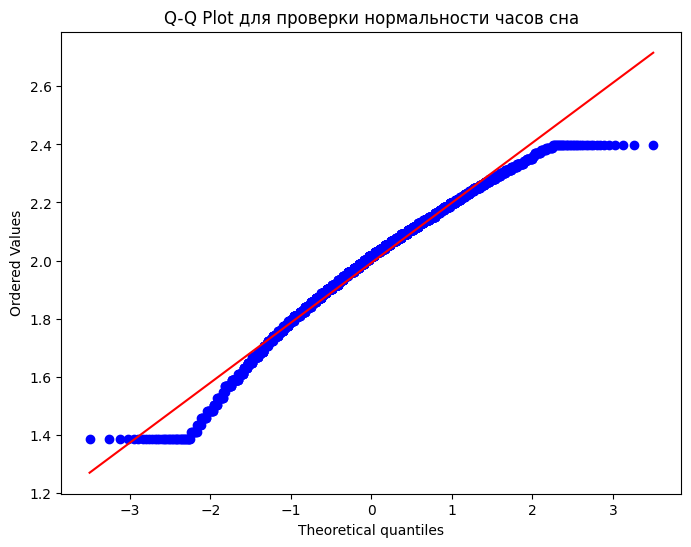

In [251]:
qqplot(data_log)

Статистика хи квадрат стала сильно дальше от заветного трешолда, как и модули оценок асимметрии и эксцесса. Аналогично на Q-Qplot, график стал ещё дальше от соответствия прямой линии.

Обработка данных, для приведения их к нормальному виду при помощи усечения выбросов:

In [252]:

def winsorize_data(data, lower_percentile=1, upper_percentile=99):
    lower_bound = np.percentile(data, lower_percentile)
    upper_bound = np.percentile(data, upper_percentile)
    
    data_winsorized = data.copy()
    data_winsorized[data_winsorized < lower_bound] = lower_bound
    data_winsorized[data_winsorized > upper_bound] = upper_bound
    
    return data_winsorized


data_winsorized_1 = winsorize_data(data, 1, 99)
data_winsorized_5 = winsorize_data(data, 5, 95)

print(f"\nУСЕЧЕНИЕ ВЫБРОСОВ:")
print(f"1%-99% усечение: [{np.min(data_winsorized_1):.2f}, {np.max(data_winsorized_1):.2f}]")
print(f"5%-95% усечение: [{np.min(data_winsorized_5):.2f}, {np.max(data_winsorized_5):.2f}]")


УСЕЧЕНИЕ ВЫБРОСОВ:
1%-99% усечение: [3.00, 10.00]
5%-95% усечение: [4.00, 9.00]


ХАРАКТЕРИСТИКИ ДАННЫХ:
Среднее: 6.4898
Дисперсия: 2.2222
Мода: 6.1000
Медиана: 6.5000
Квантиль 0.25: 5.5000
Квантиль 0.5: 6.5000
Квантиль 0.75: 7.5000
Асимметрия: 0.0119
Эксцесс: -0.2954
Интерквартильный размах (IQR): 2.0000


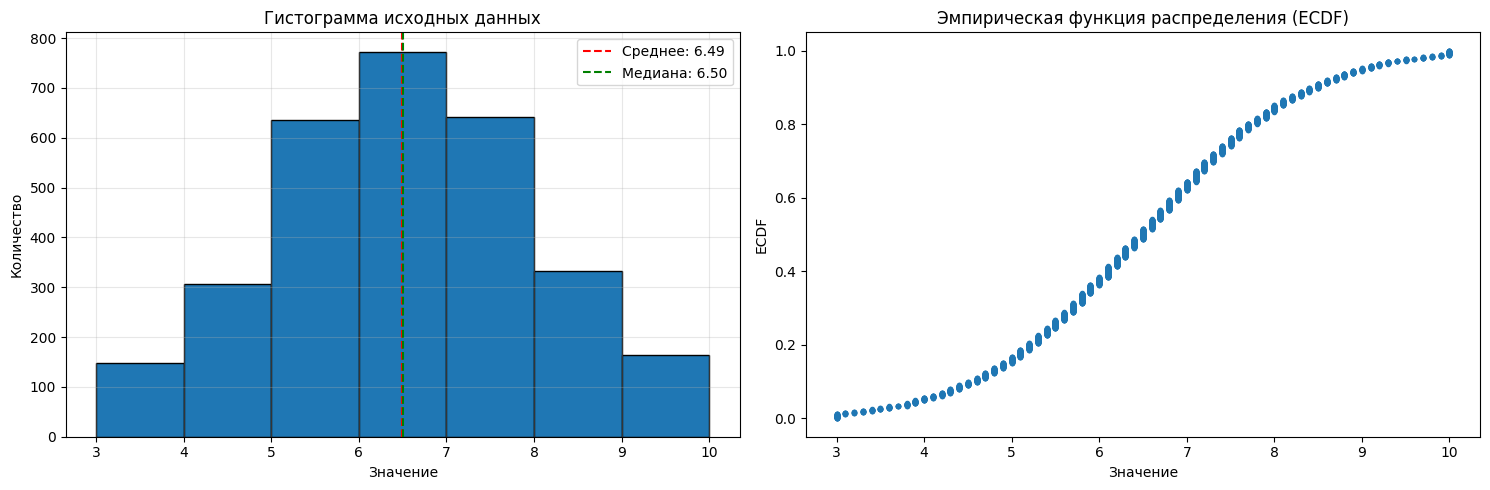

ХАРАКТЕРИСТИКИ ДАННЫХ:
Среднее: 6.4902
Дисперсия: 1.9087
Мода: 4.0000
Медиана: 6.5000
Квантиль 0.25: 5.5000
Квантиль 0.5: 6.5000
Квантиль 0.75: 7.5000
Асимметрия: 0.0145
Эксцесс: -0.8063
Интерквартильный размах (IQR): 2.0000


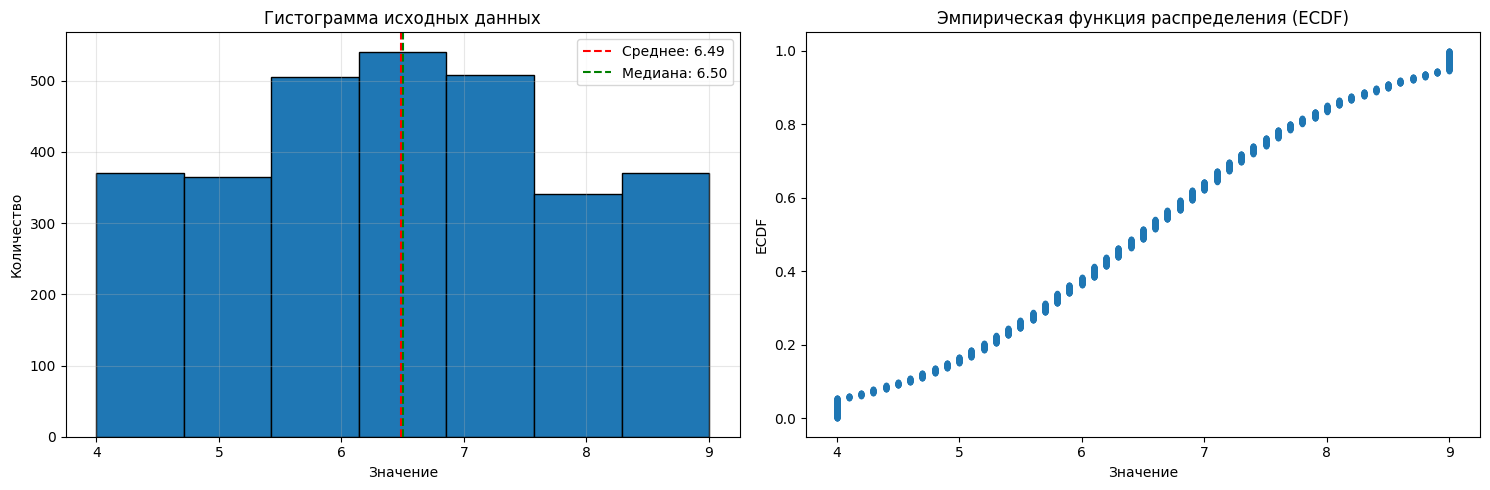

In [253]:
characteristics_solve(data_winsorized_1)
characteristics_solve(data_winsorized_5)

Как видим при отсечении 1% данных ничего не меняется, а при отсечении 5% данных происходит следующее. Всё ещё есть симметричность за счет почти нулевой ассиметрии и совпадения медианы и мат ожидания, однако имеются сильные отличия в моде. Уменьшилась дисперсия, что свидетельствует о меньшем разбросе данных. Сильнее увеличилился эксцесс, что свидетельствует о более плоском распределении по сравнению с нормальным. На графиках также видно, что попытка сделать распределение нормальным провалилась. Ну ладно, глянем на результаты критериев. 

In [254]:

chi2_stat, chi2_critical = pirson(data_winsorized_1)

print("РЕЗУЛЬТАТЫ КРИТЕРИЯ ХИ-КВАДРАТ:")
print(f"Статистика: хи квадрат = {chi2_stat:.4f}")
print(f"Критическое значение (α=0.05): {chi2_critical:.4f}")
if chi2_stat > chi2_critical:
    print("Вывод: Отвергаем нулевую гипотезу. Распределение НЕ является нормальным.")
else:
    print("Вывод: Не отвергаем нулевую гипотезу. Нет оснований считать распределение отличным от нормального.")

РЕЗУЛЬТАТЫ КРИТЕРИЯ ХИ-КВАДРАТ:
Статистика: хи квадрат = 66.8627
Критическое значение (α=0.05): 16.9190
Вывод: Отвергаем нулевую гипотезу. Распределение НЕ является нормальным.


In [255]:

chi2_stat, chi2_critical = pirson(data_winsorized_5)

print("РЕЗУЛЬТАТЫ КРИТЕРИЯ ХИ-КВАДРАТ:")
print(f"Статистика: хи квадрат = {chi2_stat:.4f}")
print(f"Критическое значение (α=0.05): {chi2_critical:.4f}")
if chi2_stat > chi2_critical:
    print("Вывод: Отвергаем нулевую гипотезу. Распределение НЕ является нормальным.")
else:
    print("Вывод: Не отвергаем нулевую гипотезу. Нет оснований считать распределение отличным от нормального.")

РЕЗУЛЬТАТЫ КРИТЕРИЯ ХИ-КВАДРАТ:
Статистика: хи квадрат = 705.1479
Критическое значение (α=0.05): 16.9190
Вывод: Отвергаем нулевую гипотезу. Распределение НЕ является нормальным.


In [256]:
skew_kurtosis_solve(data_winsorized_1)
skew_kurtosis_solve(data_winsorized_5)


РЕЗУЛЬТАТЫ КРИТЕРИЯ АСИММЕТРИИ И ЭКСЦЕССА:
Z-оценка асимметрии: 0.2652 (критическое значение ±1.9600)
Z-оценка эксцесса: -3.3059 (критическое значение ±1.9600)
Вывод: Хотя бы один из коэффициентов значимо отличается от нуля. Распределение НЕ является нормальным.

РЕЗУЛЬТАТЫ КРИТЕРИЯ АСИММЕТРИИ И ЭКСЦЕССА:
Z-оценка асимметрии: 0.3241 (критическое значение ±1.9600)
Z-оценка эксцесса: -9.0227 (критическое значение ±1.9600)
Вывод: Хотя бы один из коэффициентов значимо отличается от нуля. Распределение НЕ является нормальным.


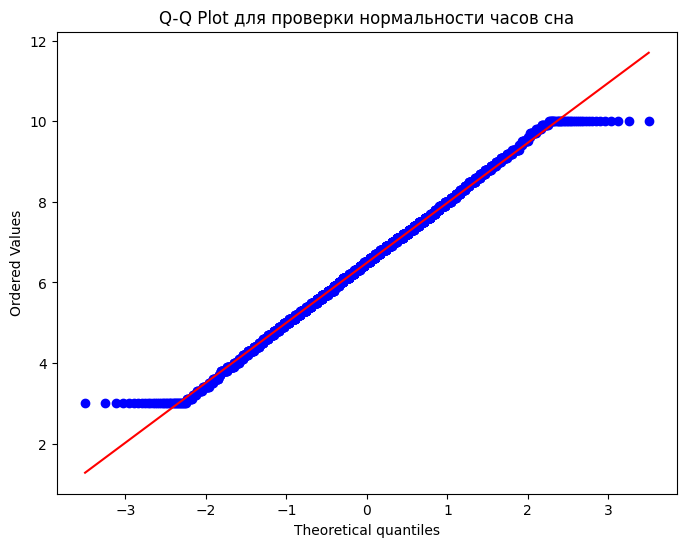

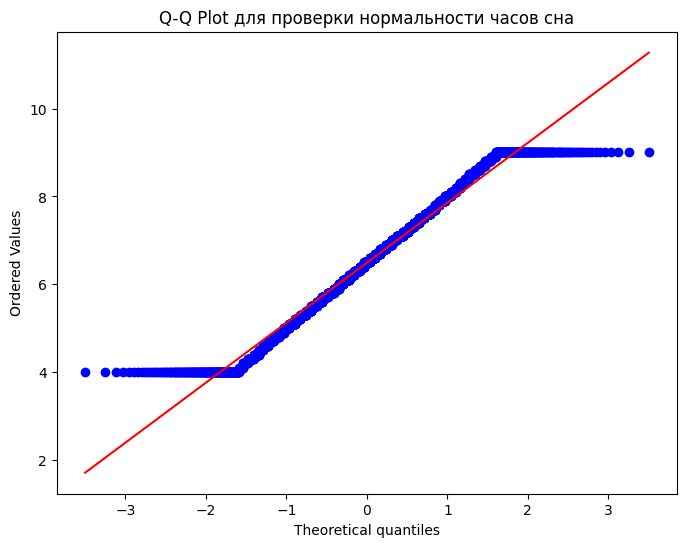

In [257]:
qqplot(data_winsorized_1)
qqplot(data_winsorized_5)

Касаемо Q-Qplot также соответствие графика прямой линии не улучшилось.

Таким образом привести данные к нормальному распределению не удалось.

Среднее и дисперсия по классам:
              mean   var
School_Grade            
10th          6.49  2.10
11th          6.37  2.11
12th          6.46  2.20
7th           6.48  2.29
8th           6.68  2.41
9th           6.47  2.20


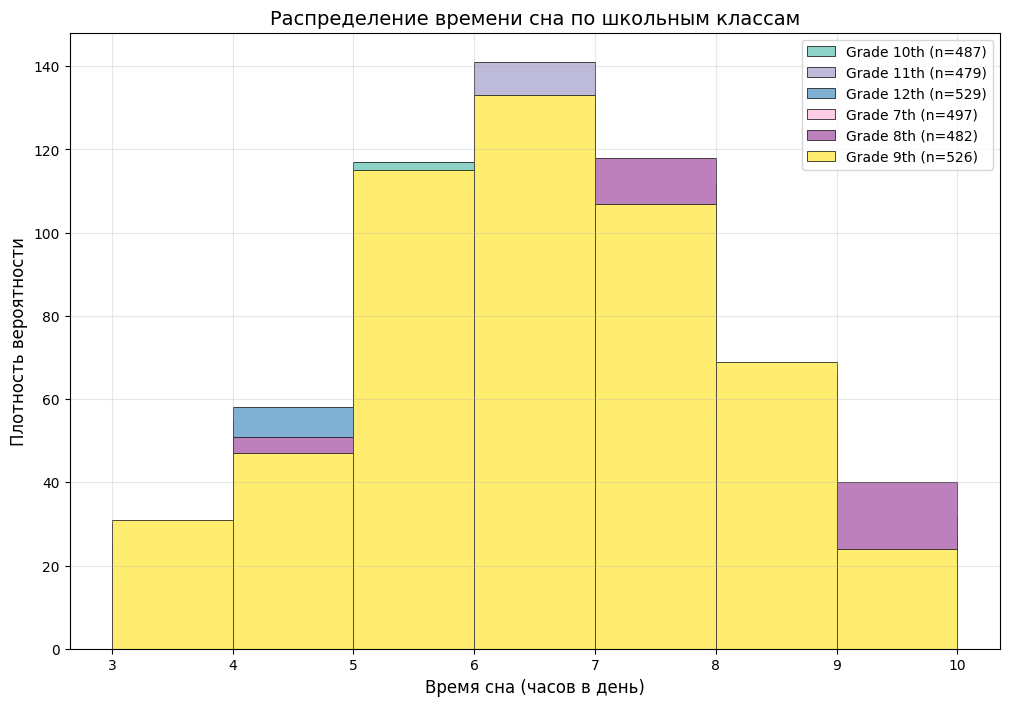

In [258]:

grouped = df.groupby('School_Grade')[selected_column]

group_stats = grouped.agg(['mean', 'var']).round(2)
print("Среднее и дисперсия по классам:")
print(group_stats)

plt.figure(figsize=(12, 8))
grades = sorted(df['School_Grade'].unique())

colors = plt.cm.Set3(np.linspace(0, 1, len(grades)))
alpha = 1

for i, grade in enumerate(grades):
    grade_data = df[df['School_Grade'] == grade][selected_column].dropna()
    
    plt.hist(grade_data, bins=7, alpha=alpha, color=colors[i], 
             edgecolor='black', linewidth=0.5, 
             label=f'Grade {grade} (n={len(grade_data)})')

plt.title('Распределение времени сна по школьным классам', fontsize=14)
plt.xlabel('Время сна (часов в день)', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Наибольшее среднее время сна: 8-й класс (6.68 часа)

Наименьшее среднее время сна: 11-й класс (6.37 часа)

Разброс средних значений: от 6.37 до 6.68 часа (разница 0.31 часа)

Наименьший разброс: 10-й класс (дисперсия = 2.10)

Наибольший разброс: 8-й класс (дисперсия = 2.41)

Разброс дисперсий: от 2.10 до 2.41 (разница 0.31)

Таким образом спит больше всего 8-й класс, что в целом логично, меньше всего спит 11-й класс, что тоже в целом логично, однако следует отметить, что разница небольшая.
Как и общее распределение времени сна, так и распределение времени сна по классам по отдельности по графику сильно похоже на нормальное, однако имеет существенные отличия от него на концах.

